# A Primer on Transformers in Single Cell Genomics

## Outline

* **1. Introduction**
* **2. Installation Guide**
* **3. Data**
* **4. Visualization**
* **5. Transformer Architecture and Training**
* **6. Evaluation**
* **7. Interpretation**

---

# Introduction

This primer introduces the use of Transformers in the field of single-cell data analysis, specifically for cell type annotation. Originally designed for natural language processing (NLP), Transformers have been adapted to tackle complex patterns in high-dimensional biological data such as single-cell RNA sequencing (scRNA-seq). This adaptation is promising for genomics because Transformers can effectively handle the sequential and complex nature of biological data, capturing dependencies and patterns that are crucial for accurate annotation.

This primer serves as a guide to applying a Transformer model to annotate single-cell data. It assumes the reader to be familiar with the main principles of single cell technology, the Python language and the functionalities of the [Scanpy](https://scanpy.readthedocs.io/en/stable/) and [Anndata](https://anndata.readthedocs.io/en/latest/) packages.
![](https://drive.google.com/uc?export=view&id=1oWpQhF5FnT1c554XcLNM0BhjANZ4sHg1)


---

Figure 1: Schematic representation of a Transformer applied to cell type annotation in scRNA-seq data. Detailed discussion is provided in the main text of the paper.



## Installation Guide

Before we begin, ensure that the necessary packages are installed. We will need `Scanpy` for single-cell analysis and `Transformers` from Hugging Face for our Transformer models. Use the following commands to install these packages:


- To install **Scanpy**, use this command in a notebook cell:
  ```python
  !pip install scanpy

- To install **Transformers**, use this command in a notebook cell:
```python
!pip install transformers





In [ ]:
!pip install scanpy
!pip install transformers

# Data


- We will be working with a dataset of 3,000 Peripheral Blood Mononuclear Cells (PBMCs) from a healthy donor. This dataset is publicly available through 10x Genomics and is commonly used in the Scanpy tutorials. Peripheral Blood Mononuclear Cells (PBMCs) are blood cells with a single round nucleus, such as lymphocytes, monocytes, and macrophages. These cells are crucial in the immune system to fight infections and adapt to intruders.

- For comprehensive analysis of single-cell RNA sequencing data, we will use [Scanpy](https://scanpy.readthedocs.io/en/stable/), a widely used library in the Python ecosystem.

- To handle annotated data matrices efficiently, particularly for high-dimensional biological data, explore [anndata](https://anndata.readthedocs.io/en/latest/), which provides structured data containers.


In [2]:
import scanpy as sc
adata  = sc.datasets.pbmc3k_processed()

  0%|          | 0.00/23.5M [00:00<?, ?B/s]

In [3]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'n_cells'
    uns: 'draw_graph', 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_tsne', 'X_umap', 'X_draw_graph_fr'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Visualization

* Visualization is a powerful tool to understand the data before diving into complex model training. Below, we visualize the distribution of cell types and gene expression levels across different cells. This visualization helps in assessing the quality of the data and understanding the underlying structure before applying the Transformer model.
* By coloring the points according to cell types, we can easily identify and analyze the diversity and similarity among cells in a 2D space.
* Note that the correct classification for each cell in this dataset is already available. In the remainder of the primer, we will demonstrate how to independently reproduce this classification using a Transformer model.

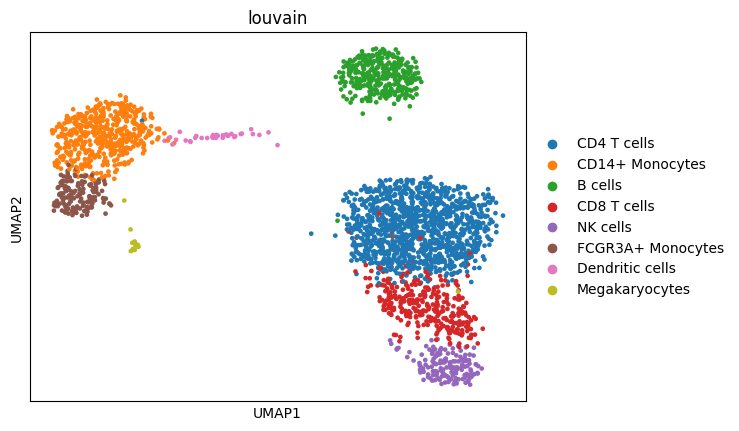

In [5]:
sc.pl.umap(adata, color='louvain')

In [6]:
adata.obs['louvain']

index
AAACATACAACCAC-1        CD4 T cells
AAACATTGAGCTAC-1            B cells
AAACATTGATCAGC-1        CD4 T cells
AAACCGTGCTTCCG-1    CD14+ Monocytes
AAACCGTGTATGCG-1           NK cells
                         ...       
TTTCGAACTCTCAT-1    CD14+ Monocytes
TTTCTACTGAGGCA-1            B cells
TTTCTACTTCCTCG-1            B cells
TTTGCATGAGAGGC-1            B cells
TTTGCATGCCTCAC-1        CD4 T cells
Name: louvain, Length: 2638, dtype: category
Categories (8, object): ['CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD8 T cells', 'NK cells',
                         'FCGR3A+ Monocytes', 'Dendritic cells', 'Megakaryocytes']

* We can also check the distribution of cell types in this data set

In [7]:
adata.obs['louvain'].value_counts()

louvain
CD4 T cells          1144
CD14+ Monocytes       480
B cells               342
CD8 T cells           316
NK cells              154
FCGR3A+ Monocytes     150
Dendritic cells        37
Megakaryocytes         15
Name: count, dtype: int64

## Data preparation



This section explains how to prepare the input data for model training.

After loading the required libraries, the `anndata` object should be used to create datasets for the PyTorch DataLoader. This involves converting gene expression values into features and cell type annotations into labels.

The data is divided into training and testing sets. The training set is utilized to train the model, while the testing set is used to evaluate the model's performance and the loss function. Typically, an 80/20 split ratio is used for training and testing, respectively. Adjust this ratio based on your specific dataset requirements.


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from scipy.sparse import issparse
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from IPython.display import clear_output
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize
from IPython.display import display, HTML
torch.manual_seed(42) # Set the seed for random number generation to ensure reproducibility.

* Creating a class that will represent gene expression values as features and cell type annotations as labels to facilitate data extraction

In [9]:
class CellDataset(Dataset):
    def __init__(self, features, labels):
        if issparse(features):
            self.features = features.toarray()
        else:
            self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

* Then we will encode cell type labels (that are in text format, e.g., 'CD4 T cells') as numbers. This is a technical requirement for labels to be processed.

In [10]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(adata.obs['louvain'])
print(f"Original labels:\n {list(adata.obs['louvain'])}\n")
print(f"New labels:\n {encoded_labels}")

Original labels:
 ['CD4 T cells', 'B cells', 'CD4 T cells', 'CD14+ Monocytes', 'NK cells', 'CD8 T cells', 'CD8 T cells', 'CD8 T cells', 'CD4 T cells', 'FCGR3A+ Monocytes', 'B cells', 'CD4 T cells', 'CD4 T cells', 'CD14+ Monocytes', 'CD8 T cells', 'CD4 T cells', 'CD14+ Monocytes', 'CD4 T cells', 'B cells', 'B cells', 'B cells', 'CD4 T cells', 'CD14+ Monocytes', 'B cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'FCGR3A+ Monocytes', 'CD8 T cells', 'B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'CD4 T cells', 'CD8 T cells', 'CD8 T cells', 'CD8 T cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'CD4 T cells', 'CD14+ Monocytes', 'CD4 T cells', 'FCGR3A+ Monocytes', 'CD14+ Monocytes', 'FCGR3A+ Monocytes', 'FCGR3A+ Monocytes', 'CD4 T cells', 'CD4 T cells', 'B cells', 'CD14+ Monocytes', 'CD4 T cells', 'CD14+ Monocytes', 'CD14+ Monocytes', 'CD4 T cells', 'CD4 T cells', 'N

* Splitting the expression data stored in (adata.X) as train and test sets.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(adata.X, encoded_labels, test_size=0.2, random_state=42)



Creating and Preparing the Dataset for Model Training




*   First, we will initialize the training and test datasets using the `CellDataset` class, passing the training features (`X_train`) and labels (`y_train`), and similarly for the test data (`X_test`, `y_test`).

*   Then, we set up the `DataLoader` for both datasets. The training loader will shuffle the data (useful for training phase to prevent model from learning the order of data), and we specify a batch size of 64. For the test loader, shuffling is set to `False` since the order of data does not impact testing.





In [12]:
train_dataset = CellDataset(X_train, y_train)
test_dataset = CellDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Transformer Architecture and Training
In the next sections, we describe how to adapt the architecture of the Transformer model for our cell type annotation task.

The model consists of multiple layers of self-attention mechanisms that process the data in parallel, which is crucial for capturing complex biological relationships. The training process involves setting up the loss function, optimizer, and number of epochs to effectively train the model on our scRNA-seq data. All these concepts are explained at large in our paper, and in the text below. Interested readers may refer to some additional material:
- the seminal paper [Attention As All You Need](https://proceedings.neurips.cc/paper_files/paper/2017/file/)
- Tutorial [The Illustrated Transformer](https://jalammar.github.io/illustrated-transformer/)






## Model Definition

<a id="model-definition"></a>


In this section, we define the architecture of our Transformer model. The architecture begins with an initial embedding layer that linearly reduces the dimensionality of dataset as shown in **Figure 2**.

[![Embedding and Transformer Encoder Layer](https://drive.google.com/uc?export=view&id=1vh-X4N7S9lEdNl-tO89b_IyeZUH8g6gj)](https://drive.google.com/uc?export=view&id=1vh-X4N7S9lEdNl-tO89b_IyeZUH8g6gj)



Figure 2: Schematic illustrating the embedding and self attention process.

The core functionality of the Transformer model is encapsulated by the `TransformerEncoderLayer` from PyTorch. This layer automatically implements all features of self-attention, including multi-head attention, layer normalization, and dropout mechanisms.

Some of the important parameters for the `TransformerEncoderLayer` are:
- `d_model`: The dimensionality of the input, which is determined by the number of output features of the embedding layer (`num_features` in our case).
- `dim_feedforward`: the dimension of the feedforward network model set to 256. Users should choose this number according to the their model and data complexity.
- `nheads`: Specifies how many times self-attention should be applied simultaneously to different parts of the input, enhancing the ability to capture contextual relationships among these parts. We use 8 heads by default, inspired by the original paper. Users should choose this number carefully to ensure that the complexity of the model aligns with the complexity of the data.
- `num_layers`: Indicates how many `TransformerEncoderLayer` instances should be stacked. This parameter is crucial for capturing the intricacies of the data. Users are encouraged to experiment with different values for `nheads` and `num_layers` to find the optimal architecture for their specific needs.




### Understanding Tokenization in Transformers

Tokenization is a fundamental preprocessing step in the application of transformer models. This step converts textual information into a numerical format that the model can understand and process efficiently. Here, we will explore how tokenization works using gene names as an example.

### Tokenization of Gene Names

* To illustrate tokenization, we'll use a list of gene names, which are typically represented textually, and convert them into numerical tokens.

* After tokenization, each integer token is converted into a dense vector through an embedding process (**Figure 2**). This vector represents the gene in a continuous vector space, facilitating the models ability to understand and process the genes features.

In [73]:
gene_names = ["BRCA1", "TP53", "EGFR", "TNF", "APOE"]

#  map each gene name to a unique integer
def tokenize_genes(gene_list):
    token_dict = {gene: idx for idx, gene in enumerate(gene_list, start=1)}
    return token_dict

tokenized_genes = tokenize_genes(gene_names)

print("Tokenization of gene names:")
for gene, token in tokenized_genes.items():
    print(f"{gene}: {token}")




Tokenization of gene names:
BRCA1: 1
TP53: 2
EGFR: 3
TNF: 4
APOE: 5


* For this Primer, we derive embeddings directly from gene expression data.

* Once we have the embeddings, we can apply the self-attention mechanism. This process allows the model to weigh the importance of each gene's features relative to others in a sequence.



In [57]:
class TransformerModel(nn.Module):
    def __init__(self, num_genes, num_features, num_classes):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(num_genes, num_features)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=num_features, dim_feedforward = 256, nhead=8)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=6)
        self.classifier = nn.Linear(num_features, num_classes)

    def forward(self, x, return_attention_weights=False):
        x = self.embedding(x)
        x = x.unsqueeze(1)
        if return_attention_weights:
            x = self.transformer_encoder(x, need_weights=True)
            x, attn_weights = x if isinstance(x, tuple) else (x, None)
        else:
            x = self.transformer_encoder(x)
        x = x.squeeze(1)
        x = self.classifier(x)
        if return_attention_weights and attn_weights is not None:
            return x, attn_weights
        return x




In [74]:
n_genes = adata.n_vars # Number of genes

num_features = 512 # An arbitrarily chosen number to embed our gene space in 512 dimensions

num_classes =  len(label_encoder.classes_)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Set device to GPU if available, otherwise CPU

model = TransformerModel(n_genes, num_features, num_classes)

model.eval()  # Ensuring the model is in evaluation mode for consistent behavior

print("Successful!\n")
print("The architecture:")
print(model)


Successful!

The architecture:
TransformerModel(
  (embedding): Linear(in_features=1838, out_features=512, bias=True)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (linear1): Linear(in_features=512, out_features=256, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=256, out_features=512, bias=True)
    (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-5): 6 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linea

## Training set up



In this section, we outline the various settings required for training our model. These configurations are pivotal as they significantly influence the model's learning and performance.

- **Loss Function**: As with any deep learning model, selecting an appropriate loss function is crucial. For this analysis, we utilize the cross-entropy loss function, which is widely used in supervised learning scenarios to compare the model's output with the actual target.
- **Optimizer**: The ADAM optimizer is chosen for adjusting the weights of the network. This optimizer is known for its efficiency in handling sparse gradients and adaptive learning rate capabilities.
- **Parameters to Optimize**: Users should focus on optimizing two key parameters during their analysis: the learning rate (`lr`) and the number of training epochs (`num_epochs`). The learning rate determines the step size at each iteration while moving toward a minimum of a loss function. The number of epochs indicates the number of times the learning algorithm will work through the entire training dataset.

Each of these settings should be carefully adjusted based on the specific characteristics and requirements of the dataset to achieve optimal performance.


In [59]:
# Training Setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, 'min')
num_epochs = 5

In [60]:
# @title Training & Validation Functions (PRESS THE RUN BUTTON on the left to skip seeing the inner workings)

def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data.float())
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        correct_predictions += (predicted == target).sum().item()
        total_samples += data.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def validate_model(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)

            output = model(data.float())
            loss = criterion(output, target)

            running_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            correct_predictions += (predicted == target).sum().item()
            total_samples += data.size(0)

    epoch_loss = running_loss / total_samples
    epoch_accuracy = correct_predictions / total_samples
    return epoch_loss, epoch_accuracy

def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output(wait=True)
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 6))

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

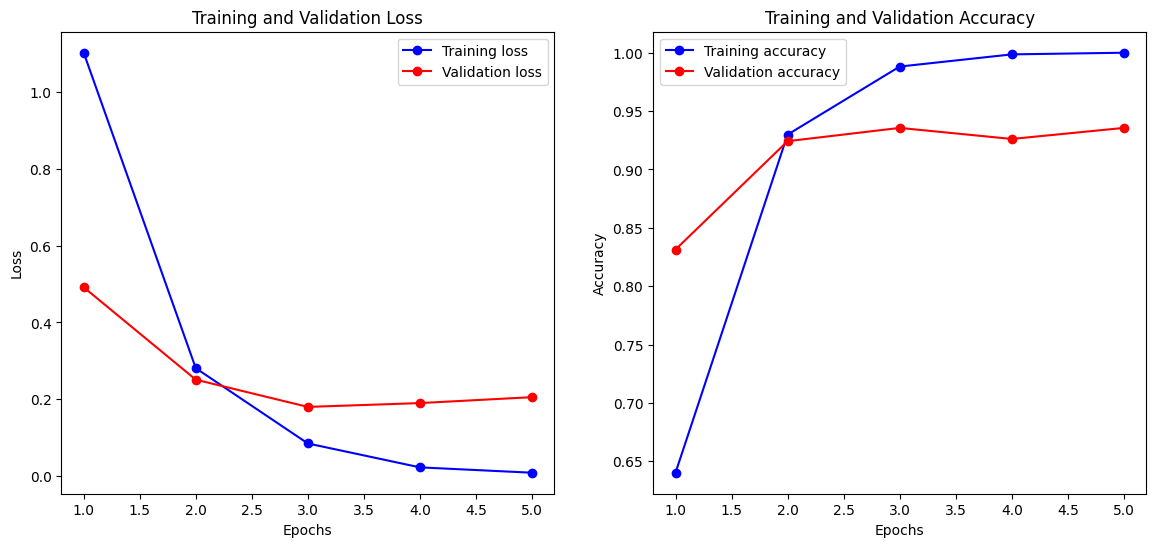


Epoch 5, Train Loss: 0.0093, Train Accuracy: 1.0000, Val Loss: 0.2057, Val Accuracy: 0.9356


In [61]:
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate_model(model, test_loader, criterion, device)
    scheduler.step(val_loss)

    # Append the metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    # Plot the metrics
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print(f'\nEpoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')



The model is finally evaluated on test data not used during the training phase

In [62]:
# @title Evaluation Function (PRESS THE RUN BUTTON on the left to skip seeing the inner workings)

def evaluate_model(model, test_loader):
    model.eval()
    all_targets, all_predictions = [], []
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data.float())
            _, predicted = torch.max(outputs.data, 1)
            all_targets.extend(target.numpy())
            all_predictions.extend(predicted.numpy())
    accuracy = accuracy_score(all_targets, all_predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(all_targets, all_predictions, average='weighted')
    return accuracy, precision, recall, f1,all_targets, all_predictions

In [63]:
accuracy, precision, recall, f1, all_targets, all_predictions = evaluate_model(model, test_loader)

print(f'Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}')

Accuracy: 0.9356, F1 Score: 0.9341


# Evaluation


In this section, we assess the performance of our model using both qualitative (visual) and quantitative methods. Initially, we will plot the model predictions against the true labels to visually inspect the alignment and discrepancies.

For a more detailed quantitative analysis, we will employ several standard machine learning metrics:
- **Confusion Matrix**: This will help us visualize the accuracy of the classification by showing the actual versus predicted classifications for each class.
- **Receiver Operating Characteristic (ROC) Curves**: These curves will be used to determine the capability of the model to distinguish between classes.
- **Area Under the Curve (AUC)**: We will compute the AUC for each class to quantify the overall ability of the model to correctly classify the different cell types.

Together, these metrics will provide a comprehensive view of the model's performance across various conditions and will aid in identifying areas for improvement.






## Qualitative Evaluation: UMAP Visualization of True and Predicted Labels

The following UMAP plots illustrate the clustering of cell types based on true labels (left) and the model’s predicted labels (right). The two plots are nearly identical, which signifies that the Transformer model effectively predicts the cell types. This visual similarity indicates a high level of accuracy in the model's performance, capturing the nuances of different cell type classifications.



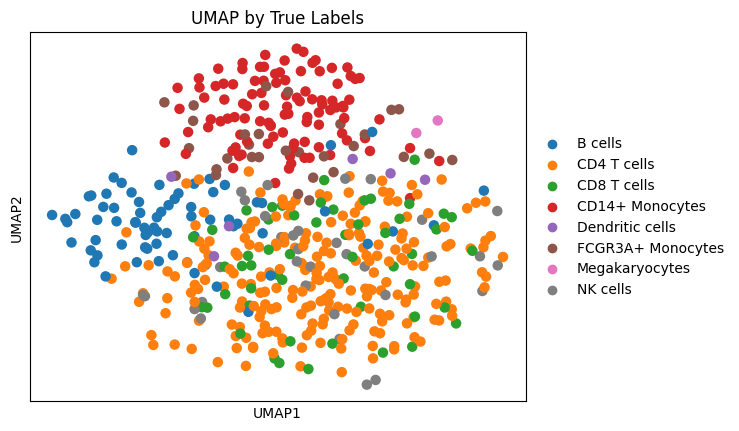

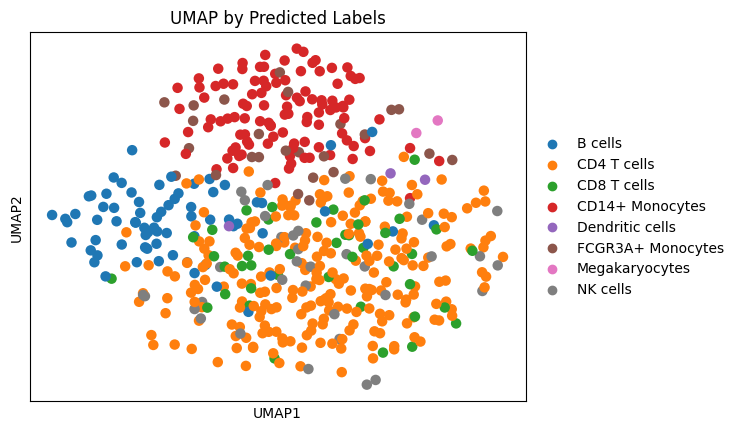

In [51]:
# Create an AnnData object for the test set
adata_test = sc.AnnData(X_test, obs={'true_labels': label_encoder.inverse_transform(y_test)})

# Compute UMAP embeddings for the test set
sc.pp.neighbors(adata_test, use_rep='X')
sc.tl.umap(adata_test)

# Add predicted labels to adata_test
adata_test.obs['predicted_labels'] = label_encoder.inverse_transform(all_predictions)

# Plot UMAP embeddings colored by true labels
sc.pl.umap(adata_test, color=['true_labels'], title='UMAP by True Labels')

# Plot UMAP embeddings colored by predicted labels
sc.pl.umap(adata_test, color=['predicted_labels'], title='UMAP by Predicted Labels')

## Confusion Matrix

This matrix contrasts the predicted labels (x-axis) against the true labels (y-axis), facilitating the identification of systemic misclassifications. It provides a clear visual representation of where the model performs well and where it tends to make errors.


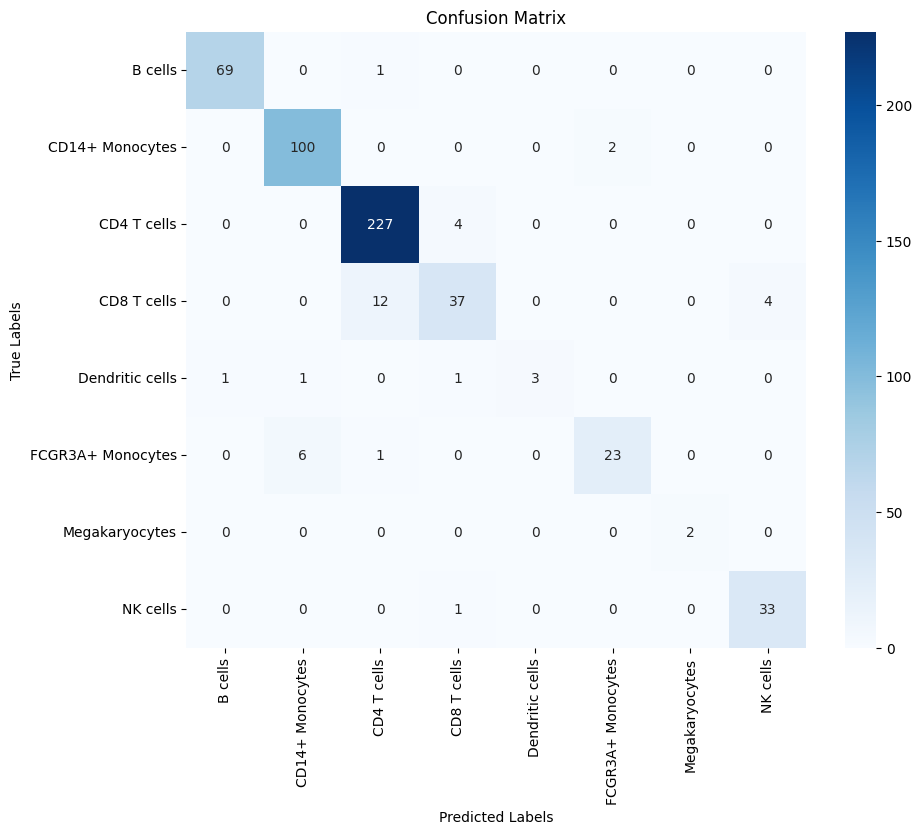

In [53]:
# loading libraries
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# this function extract the predictions from the model
def get_all_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, target in dataloader:
            outputs = model(data.float())
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(target.numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions and true labels
preds, labels = get_all_predictions(model, test_loader)

# Compute the confusion matrix
cm = confusion_matrix(labels, preds)
class_names = label_encoder.classes_

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## ROC Curve

* The code snippet calculates AUC scores for each class and then computes both macro-average and micro-average AUC scores to give a comprehensive view of the model's performance across all classes.

* Micro-average ROC considers all individual predictions equally, while macro-average ROC provides class-specific performance metrics and then averages them.

* Finally, it visualizes the ROC curves for each class along with the macro and micro-average curves.

<ipython-input-54-a43d137faf08>:49: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


Macro-average AUC: 0.9953
Micro-average AUC: 0.9964


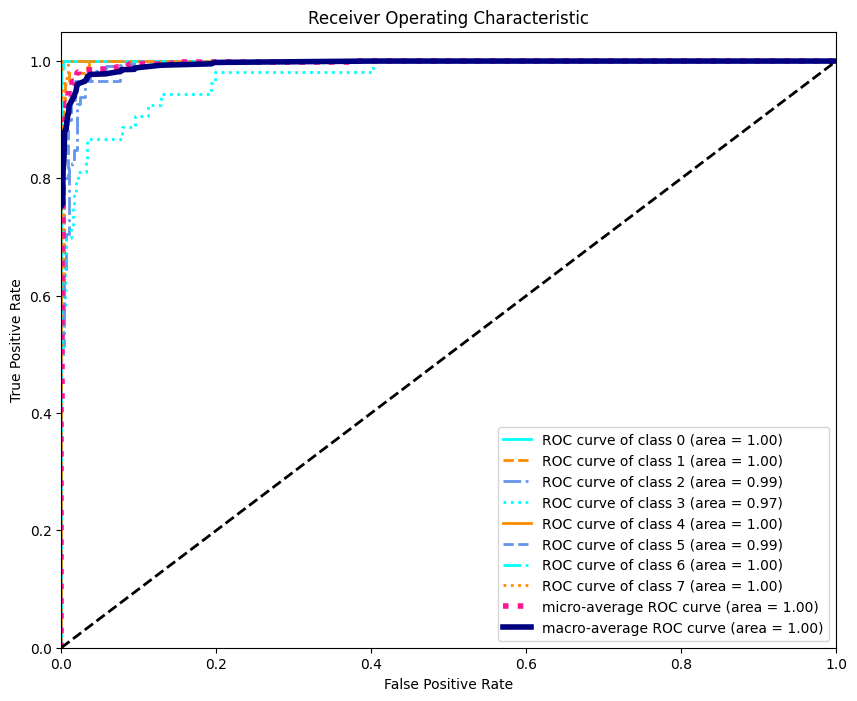

In [54]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
from scipy import interp
from itertools import cycle
from sklearn.preprocessing import label_binarize

def get_all_probabilitiesN(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []
    with torch.no_grad():
        for data, target in dataloader:
            outputs = model(data.float())
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs.numpy())
            all_labels.extend(target.numpy())
    return np.array(all_probs), np.array(all_labels)

# Get probabilities and true labels
probs, labels = get_all_probabilitiesN(model, test_loader)

n_classes = 8

labels_binarized = label_binarize(labels, classes=np.arange(n_classes))
# Binary classification
if len(class_names) == 2:
    roc_auc = roc_auc_score(labels, probs[:, 1])
    print(f'AUC: {roc_auc:.4f}')
else:
    # Multiclass classification
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(class_names)
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_binarized[:, i], probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_binarized.ravel(), probs.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f'Macro-average AUC: {roc_auc["macro"]:.4f}')
    print(f'Micro-average AUC: {roc_auc["micro"]:.4f}')


plt.figure(figsize=(10, 8))
lw = 2

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])


line_styles = cycle(['-', '--', '-.', ':'])


for i, (color, line_style) in zip(range(n_classes), cycle(zip(colors, line_styles))):
    plt.plot(fpr[i], tpr[i], color=color, linestyle=line_style, lw=lw,
             label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

# Plot the micro-average and macro-average ROC curves with distinct styles
plt.plot(fpr["micro"], tpr["micro"],
         color='deeppink', linestyle=':', linewidth=4,
         label=f'micro-average ROC curve (area = {roc_auc["micro"]:0.2f})')

plt.plot(fpr["macro"], tpr["macro"],
         color='navy', linestyle='-', linewidth=4,
         label=f'macro-average ROC curve (area = {roc_auc["macro"]:0.2f})')


plt.plot([0, 1], [0, 1], 'k--', lw=lw)

# Finalize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()





## References

1. _Attention Is All You Need_. [Link](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
2. _SCANPY: large-scale single-cell gene expression data analysis_. [Link](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-017-1382-0)
3. _Anndata - Annotated data_. [Link](https://anndata.readthedocs.io/en/latest/)


